In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import os
from PIL import Image
import torch.nn.functional as F
import random
from collections import deque
import math

In [92]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
GPU 0: NVIDIA GeForce GTX 1660 Ti
Device being used: cuda


In [93]:
class OHLCVDataset(Dataset):
    def __init__(self, file_path, window_size=20):
        self.window_size = window_size
        self.data = pd.read_csv(file_path, parse_dates=["datetime"])
        self.raw_data = self.data[["datetime", "open", "high", "low", "close", "volume"]]

        self.data['date'] = self.data['datetime'].dt.date
        self.grouped = self.data.groupby('date')

        self.daily_data = []
        for date, group in self.grouped:
            if len(group) >= self.window_size:
                self.daily_data.append(group.reset_index(drop=True))

    def __len__(self):
        return len(self.daily_data)

    def __getitem__(self, idx):
        day_data = self.daily_data[idx]
        raw_data = day_data[["open", "high", "low", "close", "volume"]].values
        normalized_data = self._normalize(raw_data)

        states = []
        for i in range(len(normalized_data) - self.window_size + 1):
            state = normalized_data[i : i + self.window_size]
            state_tensor = torch.tensor(state, dtype=torch.float32).transpose(0, 1)
            state_tensor = state_tensor.unsqueeze(0).unsqueeze(0)
            states.append(state_tensor)
        return {
            'states': states,
            'raw_data': raw_data,
            'datetimes': day_data['datetime'].values[self.window_size - 1 :],
            'dates': day_data['date'].iloc[0]
        }

    def _normalize(self, data):
        min_vals = data.min(axis=0)
        max_vals = data.max(axis=0)
        return (data - min_vals) / (max_vals - min_vals + 1e-6)

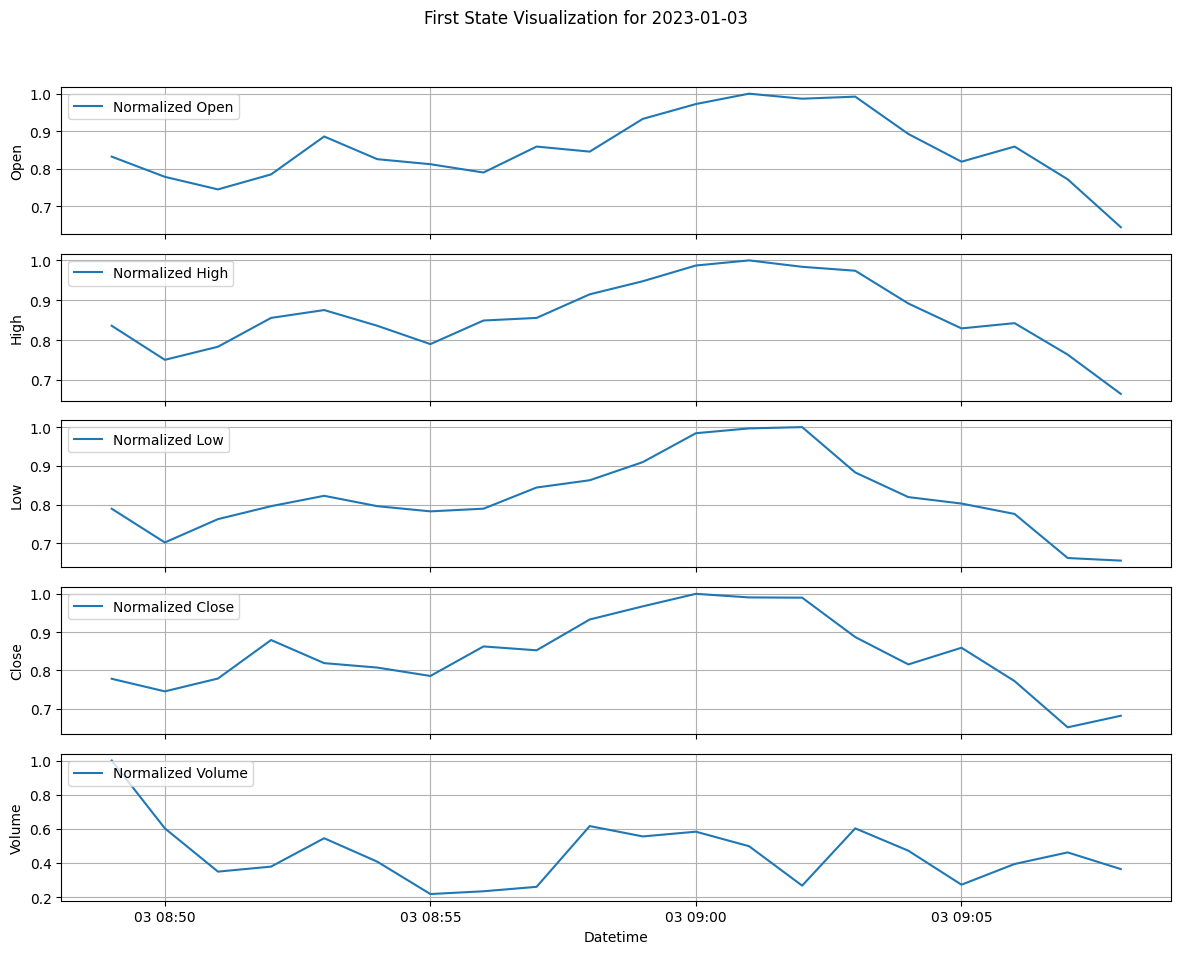

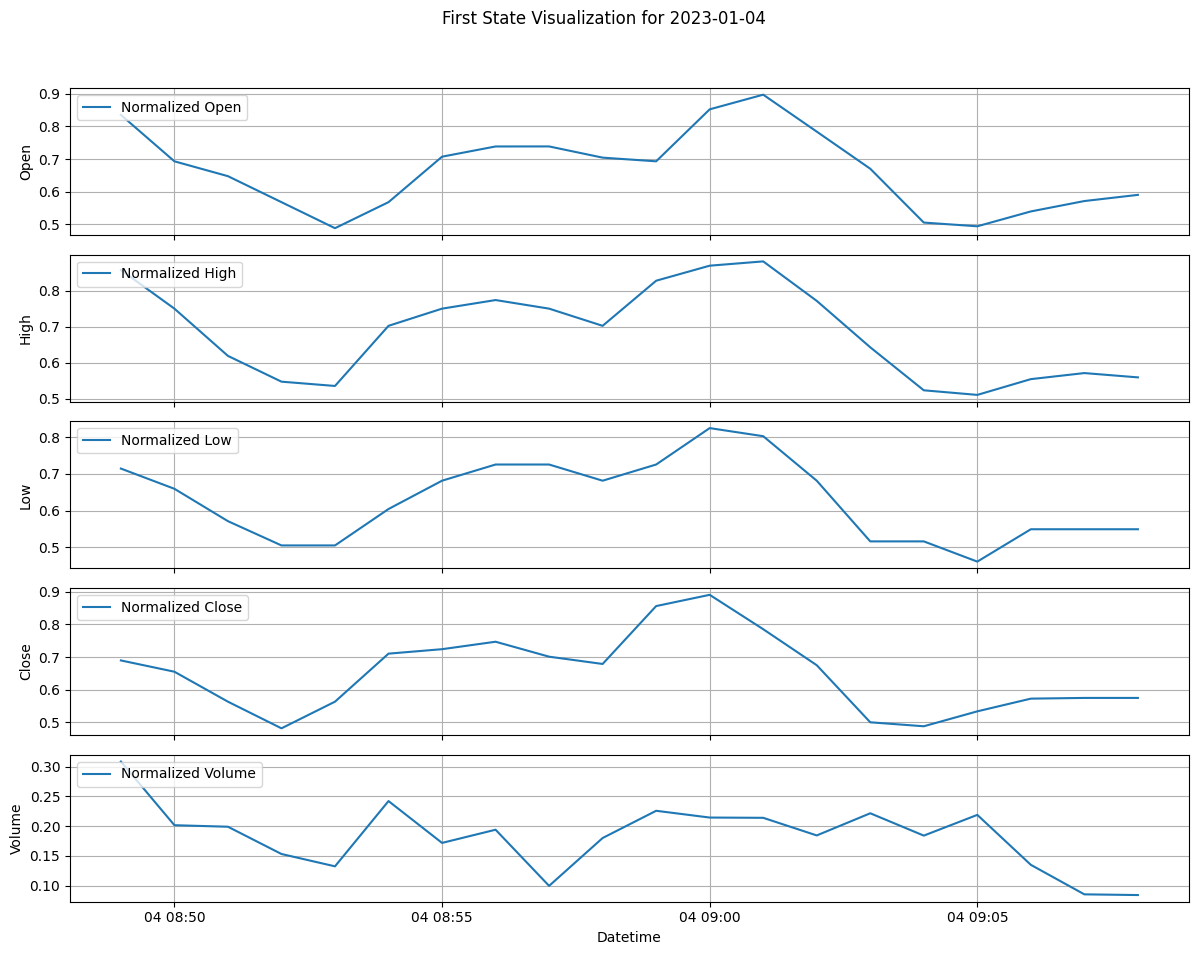

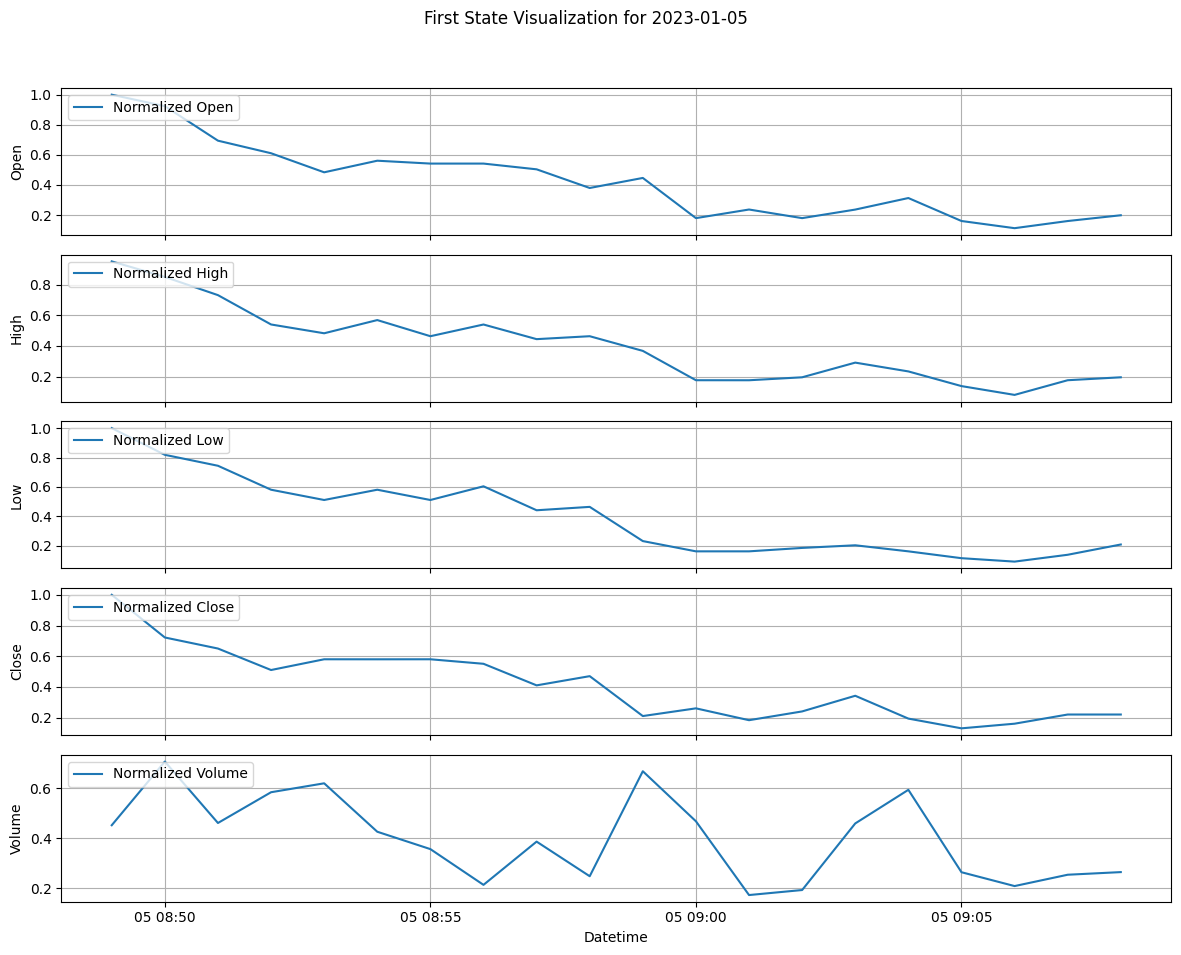

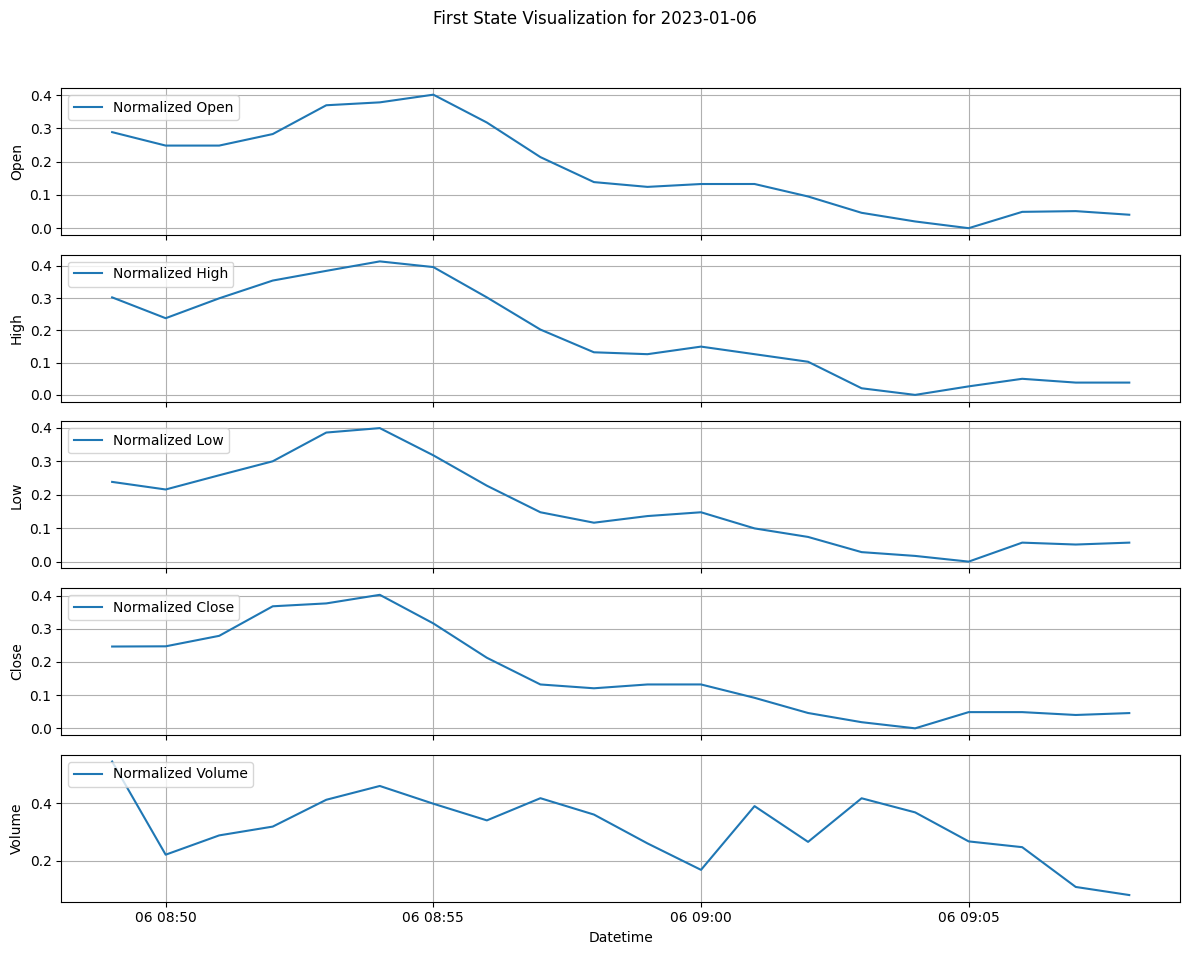

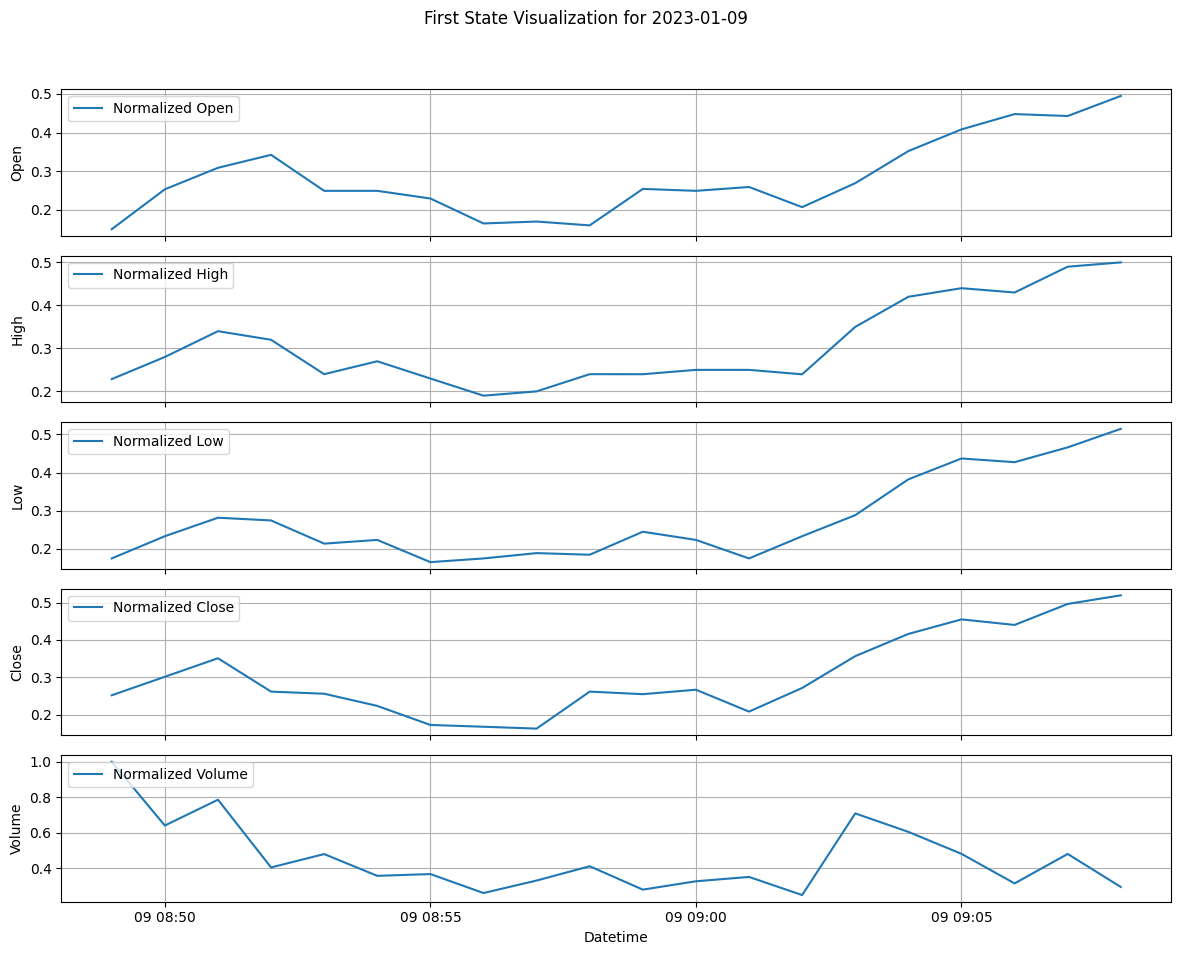

In [94]:
# Dataset visualization
file_path = "./labeling/TQQQ_minute_data_cleaned_labeled_375days.csv"
window_size = 20
dataset = OHLCVDataset(file_path, window_size=window_size)

# Select a few sample days to visualize
sample_day_indices = [0, 1, 2, 3, 4]  # First five days as examples

for idx in sample_day_indices:
    day_data = dataset[idx]
    states = day_data['states']
    raw_data = day_data['raw_data']
    datetimes = day_data['datetimes']
    date = day_data['dates']
    
    # Extract the first state (8:30-8:49)
    first_state = states[0].squeeze().numpy()  # Shape: (5, 20)
    
    # Extract the corresponding raw data for the first state
    first_raw_data = raw_data[:window_size]
    first_datetimes = datetimes[:window_size]
    
    # Plotting
    fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
    feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    for i, ax in enumerate(axes):
        ax.plot(first_datetimes, first_state[i], label=f'Normalized {feature_names[i]}')
        ax.set_ylabel(f'{feature_names[i]}')
        ax.legend(loc='upper left')
        ax.grid(True)
    
    plt.xlabel('Datetime')
    plt.suptitle(f'First State Visualization for {date}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [95]:
class SingleScale1D(nn.Module):
    def __init__(self, input_channels=5, output_channels=5, kernel_size=3):
        super(SingleScale1D, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        return x

In [96]:
class ThreeByThreeConv2D(nn.Module):
    def __init__(self, input_channels=1, output_channels=2, kernel_size=3):
        super(ThreeByThreeConv2D, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)
        return x

In [97]:
class FiveByFiveConv2D(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, kernel_size=5):
        super(FiveByFiveConv2D, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)
        return x

In [98]:
class MultiScaleNet(nn.Module):
    def __init__(self, height=5, width=20):
        super(MultiScaleNet, self).__init__()
        self.single_scale_1d = SingleScale1D(input_channels=5, output_channels=5, kernel_size=3)
        self.three_by_three = ThreeByThreeConv2D(input_channels=1, output_channels=2, kernel_size=3)
        self.five_by_five = FiveByFiveConv2D(input_channels=1, output_channels=1, kernel_size=5)
        self.height = height
        self.width = width

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        x_1d = x.view(batch_size, height, width)
        features_1d = self.single_scale_1d(x_1d)

        features_1d = features_1d.mean(dim=2, keepdim=True)
        features_1d = features_1d.view(batch_size, 5, 1, 1)
        features_1d = F.interpolate(features_1d, size=(height, width), mode='bilinear', align_corners=False)

        features_3x3 = self.three_by_three(x)
        features_5x5 = self.five_by_five(x)

        combined_features = torch.cat((features_1d, features_3x3, features_5x5), dim=1)
        
        return combined_features

In [99]:
class ECABlock(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super(ECABlock, self).__init__()
        t = int(abs((math.log(channels, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = y.squeeze(-1).transpose(-1, -2)
        y = self.conv(y)
        y = self.sigmoid(y)
        y = y.transpose(-1, -2).unsqueeze(-1)
        return x * y.expand_as(x)

In [100]:
class Backbone(nn.Module):
    def __init__(self, input_channels=8):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.eca = ECABlock(64)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.eca(x)
        return x

In [101]:
class MSNetWithBackbone(nn.Module):
    def __init__(self):
        super(MSNetWithBackbone, self).__init__()
        self.multi_scale_net = MultiScaleNet()
        self.backbone = Backbone(input_channels=8)

    def forward(self, x):
        x = self.multi_scale_net(x)
        x = self.backbone(x)
        return x

In [102]:
class MSNetWithQValue(nn.Module):
    def __init__(self, num_actions=3):
        super(MSNetWithQValue, self).__init__()
        self.multi_scale_with_backbone = MSNetWithBackbone()

        self.conv_final = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        
        sample_input = torch.randn(1, 1, 5, 20)
        sample_output = self.multi_scale_with_backbone(sample_input)
        sample_output = self.conv_final(sample_output)
        feature_map_size = sample_output.view(-1).size(0)

        self.fc1 = nn.Linear(feature_map_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = self.multi_scale_with_backbone(x)
        x = self.conv_final(x)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [103]:
# Create MS-CNN and ensure the output shape is the correct size (3 Q values: 1 for each action)
model = MSNetWithQValue(num_actions=3)
test_input = torch.randn(1, 1, 5, 20)
output = model(test_input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3])


In [104]:
class ReplayBuffer:
    # Initialize buffer as a double ended queue
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    # Push a state, action, reward, next_state, done tuple on the buffer
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # Randomly sample
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        state_batch = torch.cat(state, dim=0)
        next_state_batch = torch.cat(next_state, dim=0)
        return (
            state_batch,
            torch.tensor(action, dtype=torch.long),
            torch.tensor(reward, dtype=torch.float32),
            next_state_batch,
            torch.tensor(done, dtype=torch.float32),
        )

    # Override buffer's length method and return length
    def __len__(self):
        return len(self.buffer)

In [105]:
class DDQNAgent:
    def __init__(self, buffer_capacity, gamma=0.99, lr=1e-3, target_update_freq=100):
        self.actor = MSNetWithQValue()
        self.target = MSNetWithQValue()
        self.target.load_state_dict(self.actor.state_dict())
        self.target.eval()

        self.buffer = ReplayBuffer(buffer_capacity)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.steps = 0
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995

        self.position = 'sold_out'

    # Select an action based on current state
    def select_action(self, state):
        # Exploration block. 
        # If bought in and told to hold or buy randomly, hold. 
        # If sold out and told to hold or sell randomly, sell.
        if random.random() < self.epsilon:
            random_action = random.randint(0,2)
            if self.position == 'bought_in':
                if random_action in [0, 1]:
                    return 0
                else:
                    return 2
            else:
                if random_action in [0, 2]:
                    return 0
                else:
                    return 1
        # Eploitation block.
        # Select action with highest Q value
        else:
            with torch.no_grad():
                q_values = self.actor(state)
                max_q, max_action = q_values.max(dim=1)
                max_action = max_action.item()
                
                if self.position == 'bought_in':
                    if max_action in [0, 1]:
                        return 0
                    else:
                        return 2
                else:
                    if max_action in [0, 2]:
                        return 0
                    else:
                        return 1

        return 0

    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.buffer.sample(batch_size)

        with torch.no_grad():
            next_q_values = self.actor(next_state_batch)
            next_actions = next_q_values.argmax(dim=1)
            target_q_values = self.target(next_state_batch)
            target_q = reward_batch + self.gamma * (1 - done_batch) * target_q_values[range(batch_size), next_actions]

        current_q = self.actor(state_batch)[range(batch_size), action_batch]

        loss = F.mse_loss(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % self.target_update_freq == 0:
            self.target.load_state_dict(self.actor.state_dict())

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.steps += 1

    def store_transition(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)

In [ ]:
class StockTradingEnvWithFeatures:
    def __init__(self, daily_dataset, k=5):
        self.daily_dataset = daily_dataset
        self.current_day = 0
        self.num_days = len(daily_dataset)
        self.k = k

        self.current_step = 0
        self.done = False
        self.price_history = []
        self.initial_cash = 500000
        self.cash_balance = self.initial_cash
        self.total_asset_value = self.cash_balance
        self.previous_total_asset_value = self.total_asset_value
        self.trade_log = []
        self.cost_basis = 0.0
        self.shares_held = 0

        self.reset()

    def reset(self):
        self.current_step = 0
        self.done = False
        self.price_history = []
        self.initial_cash = 500000
        self.cash_balance = self.initial_cash
        self.total_asset_value = self.cash_balance
        self.previous_total_asset_value = self.total_asset_value
        self.trade_log = []
        self.cost_basis = 0.0
        self.shares_held = 0

        if self.current_day >= self.num_days:
            self.done = True
            return None

        day_data = self.daily_dataset[self.current_day]
        self.states = day_data['states']
        self.raw_data = day_data['raw_data']
        self.datetimes = day_data['datetimes']
        self.window_size = self.states[0].shape[-1]
        self.num_steps = len(self.states)
        self.raw_close_prices = self.raw_data[self.window_size - 1 :, 3]

        self.current_day += 1

        return self._get_state()

    def _get_state(self):
        if self.current_step >= self.num_steps:
            self.done = True
            return None

        state = self.states[self.current_step]
        current_close_price = self.raw_data[self.current_step + self.window_size - 1, 3]
        self.price_history.append(current_close_price)
        return state

    def step(self, action):
        if self.current_step + 1 < self.num_steps:
            state = self.states[self.current_step]
            current_close_price = self.raw_close_prices[self.current_step]
            next_close_price = self.raw_close_prices[self.current_step + 1]
            datetime = self.datetimes[self.current_step]

            datetime = self.datetimes[self.current_step]

            profit = 0

            if action == 1:
                if current_close_price == 0:
                    num_shares = 0
                else:
                    num_shares = int(self.cash_balance / current_close_price)
                total_cost = num_shares * current_close_price
                self.cash_balance -= total_cost
                self.shares_held += num_shares
                self.cost_basis += total_cost

            elif action == 2:
                num_shares = self.shares_held
                total_proceeds = num_shares * current_close_price
                self.cash_balance += total_proceeds
                self.shares_held = 0
                profit = total_proceeds - self.cost_basis
                self.cost_basis = 0
            
            else:
                profit = 0.0

            self.previous_total_asset_value = self.total_asset_value
            self.total_asset_value = self.cash_balance + self.shares_held * current_close_price

            profit = self.total_asset_value - self.previous_total_asset_value

            reward = self.calculate_profit_reward(action, current_close_price)

            action_mapping = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
            trade_info = {
                'datetime': datetime,
                'action': action_mapping[action],
                'reward': reward,
                'profit': profit,
                'total_asset_value': self.total_asset_value,
                'cash_balance': self.cash_balance,
                'shares_held': self.shares_held,
                'position': 'bought_in' if self.shares_held > 0 else 'sold_out'
            }
            self.trade_log.append(trade_info)

            self.current_step += 1
            done = self.current_step >= self.num_steps - 1
            return self._get_state(), reward, done, {}
        else:
            self.done = True
            return None, 0, True, {}

    def calculate_reward(self, action, current_close_price):
        POS_t = 1 if self.shares_held > 0 else 0

        R_k_t = []
        for i in range(1, self.k + 1):
            future_step = self.current_step + i
            if future_step >= self.num_steps:
                break
            future_price = self.raw_close_prices[future_step]
            if current_close_price == 0:
                R_k_t_i = 0
            else:
                R_k_t_i = (future_price - current_close_price) / current_close_price
            R_k_t.append(R_k_t_i)

        if len(R_k_t) < 2:
            SR_t = 0
        else:
            mean_R = np.mean(R_k_t)
            std_R = np.std(R_k_t)
            if std_R == 0:
                SR_t = 0
            else:
                SR_t = mean_R / std_R

        SSR_t = POS_t * SR_t

        return SSR_t
    
    def calculate_profit_reward(self, action, current_close_price):
        POS_t = 1 if self.shares_held > 0 else 0

        if POS_t == 0:
            return 0.0

        weighted_cumulative_return = 0.0
        total_weight = 0.0

        for i in range(1, self.k + 1):
            future_step = self.current_step + i
            if future_step >= self.num_steps:
                break
            future_price = self.raw_close_prices[future_step]
            if current_close_price == 0:
                R_k_t_i = 0
            else:
                R_k_t_i = (future_price - current_close_price) / current_close_price
            weight = (self.k - i + 1)
            weighted_cumulative_return += weight * R_k_t_i
            total_weight += weight

        if total_weight == 0:
            return 0.0

        normalized_weighted_return = weighted_cumulative_return / total_weight

        return normalized_weighted_return

In [ ]:
# Initialize data, environment, agent, and variables
file_path = "./labeling/TQQQ_minute_data_cleaned_labeled_375days.csv"
dataset = OHLCVDataset(file_path)
env = StockTradingEnvWithFeatures(dataset)
agent = DDQNAgent(buffer_capacity=10000)
batch_size = 32
num_days = len(dataset)

# For each day in the training dataset, train the DDQNAgent
for day in range(num_days):
    state = env.reset()
    done = False
    total_reward = 0

    # While still in the day, keep training on that day
    while not done and state is not None:
        # Select an action based upon Q values returned from MS-CNN
        action = agent.select_action(state)

        # Calculate what that action does
        next_state, reward, done, _ = env.step(action)

        # Store the transition in the replay/lookback buffer
        agent.store_transition(state, action, reward, next_state, done)

        # Train agent by updating networks to perform better calculations
        agent.train(batch_size)

        # Update Agent's Position
        if action == 1:
            agent.position = 'bought_in'
        elif action == 2:
            agent.position = 'sold_out'

        # Increment state and add reward to total reward
        state = next_state
        total_reward += reward

    # If training day is done and shares are still being held, sell
    if env.shares_held > 0:
        last_close_price = env.raw_data[env.current_step + env.window_size - 1, 3]
        total_proceeds = env.shares_held * last_close_price
        profit = total_proceeds - env.cost_basis
        env.cash_balance += total_proceeds
        env.shares_held = 0
        env.cost_basis = 0.0
        env.total_asset_value = env.cash_balance

        # Logging
        trade_info = {
            'datetime': env.datetimes[-1],
            'action': 'Sell (EOD)',
            'reward': 0.0,
            'profit': profit,
            'total_asset_value': env.total_asset_value,
            'cash_balance': env.cash_balance,
            'shares_held': env.shares_held,
            'position': 'sold_out'
        }
        env.trade_log.append(trade_info)

        # Update Agent's Position
        agent.position = 'sold_out'

    # Calculate profit and print training info
    total_profit = env.total_asset_value - env.initial_cash
    print(f"Day {day + 1}/{num_days}, Total Reward: {total_reward}, Total Profit: {total_profit}")

    # Convert trade log to csv for each day to see what decisions the bot is making
    trade_log = env.trade_log
    trade_log_df = pd.DataFrame(trade_log)
    trade_log_df.to_csv(f"./testing/trade_log_day_{day + 1}.csv", index=False)